In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as v2 
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torch.nn.functional as F
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
import pickle

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
import os
import numpy as np

In [2]:
#!/bin/bash
# !kaggle datasets download soumikrakshit/nyu-depth-v2
# !unzip nyu-depth-v2.zip
# !kaggle datasets download akash2sharma/tiny-imagenet
# !unzip tiny-imagenet.zip

In [3]:
class DepthwiseSeparableConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, stride_depth = 1, stride_pointwise = 1):
        super().__init__()
        self.conv_depth = nn.Conv2d(in_channels = in_channels, out_channels=in_channels, kernel_size=(3,3), padding=1, stride=stride_depth, groups=in_channels)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.conv_pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, stride=stride_pointwise, kernel_size=1, groups=1)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv_depth(x)))
        return self.relu(self.bn2(self.conv_pointwise(x))) 



class DepthwiseUpSampleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_depth = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=(5,5), padding=2, groups=out_channels)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(num_features=out_channels) 
    
    def forward(self, x):
        x  = self.relu(self.bn1(self.conv_depth(x)))
        return F.interpolate(x, scale_factor=2, mode='nearest')
        
class MobileNet(nn.Module):
    def __init__(self, classification = False):
        super().__init__()
        self.classification = classification
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
        self.layer1 = DepthwiseSeparableConvolution(32, 64)
        self.layer2 = DepthwiseSeparableConvolution(64, 128, stride_depth=2)
        self.layer3 = DepthwiseSeparableConvolution(128, 128)
        self.layer4 = DepthwiseSeparableConvolution(128, 128, stride_depth=2)
        self.layer5 = DepthwiseSeparableConvolution(128, 256)
        self.layer6 = DepthwiseSeparableConvolution(256, 512, stride_depth=2)
        self.same_layer_sequence = nn.Sequential(*[DepthwiseSeparableConvolution(512, 512)] * 5)
        self.layer7 = DepthwiseSeparableConvolution(512, 1024, stride_depth=2)
        self.relu = nn.ReLU(inplace=True)
        self.bn32 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.relu(self.bn32(self.conv1(x)))
        third_residual = self.layer1(x)
        x = self.layer2(third_residual)
        second_residual = self.layer3(x)
        x = self.layer4(second_residual)
        first_residual = self.layer5(x)
        x = self.layer6(first_residual)
        x = self.same_layer_sequence(x)
        x = self.layer7(x)
        return x, first_residual, second_residual, third_residual
    
class MobileNetClassificationWrapper(nn.Module):
    def __init__(self, nr_classes = 200):
        super().__init__()
        self.computations = MobileNet() 
        self.classify = nn.Sequential(*[
                nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                nn.Flatten(),
                nn.Linear(1024, nr_classes),
                # nn.Softmax(dim=1),
            ])
        
    def save_model_right(self, path):
        torch.save(self.computations.state_dict(), path)
        torch.save(self.state_dict(), "./classify_model.pth")    
        
    def forward(self, x):
        x, _, _, _ = self.computations(x)
        return self.classify(x)
    

class FastDepth(nn.Module):
    def __init__(self, path : str = None):
        super().__init__()
        if (path == None):
            self.encoder = MobileNet()
        else:
            self.encoder = MobileNet()
            self.encoder.load_state_dict(torch.load(path, weights_only=True))
        self.dec1 = DepthwiseUpSampleConvolution(1024, 512)
        self.dec2 = DepthwiseUpSampleConvolution(512, 256)
        self.dec3 = DepthwiseUpSampleConvolution(256, 128)
        self.dec4 = DepthwiseUpSampleConvolution(128, 64)
        self.dec5 = DepthwiseUpSampleConvolution(64, 32)
        self.final_conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1)

    def save_model_right(self, path):
        torch.save(self.encoder.state_dict(), "fast_depth_encoder.pth")
        torch.save(self.state_dict(), path)    

    def forward(self, x):
        x, r1, r2, r3 = self.encoder(x)
        x = self.dec1(x)
        x = self.dec2(x) + r1
        x = self.dec3(x) + r2
        x = self.dec4(x) + r3
        x = self.dec5(x)
        return self.final_conv(x)

In [4]:
import torch.optim.sgd


class EarlyStopping:
    def __init__(self, model : MobileNetClassificationWrapper, patience, path):
        self.path = path
        self.patience = patience
        self.model = model
        self.current_patience = patience
        self.current_loss = float('inf')

    def should_continue(self, loss):
        if (loss < self.current_loss):
            self.current_loss = loss
            self.current_patience = self.patience
            self.model.save_model_right(self.path)
        else:
            self.current_patience -= 1
            if (self.current_patience == 0): return False
        return True

    def load_model(self):
        model = MobileNetClassificationWrapper()
        model.load_state_dict(torch.load("./classify_model.pth", weights_only=True))
        return model
    

def initialiseTrainingModelHelpers(model, parameters):
    criterion = nn.CrossEntropyLoss()    
    # optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr_optimizer'], weight_decay=parameters['weight_decay_factor'])
    optimizer = torch.optim.SGD(model.parameters(), lr=parameters['lr_optimizer'], weight_decay=parameters['weight_decay_factor'], momentum=parameters["momentum"])
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                    factor=parameters['gamma_lr'], patience=parameters['patience'])
    return criterion, optimizer, lr_scheduler


def plot_losses(train_losses: list[float], validation_losses: list[float], label_x : str, label_y : str, title : str) -> None:
    """Plots training and validation losses over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label=label_x, marker="o")
    plt.plot(validation_losses, label=label_y, marker="o")
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def train(model, dataloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    model.to(device)
    train_loss = 0
    all_preds = []
    all_labels= []
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        all_preds.extend(torch.argmax(outputs.cpu(), dim=1).detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
    return train_loss / len(dataloader), accuracy_score(all_preds, all_labels)

def test(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    with torch.no_grad():
        validation_loss = 0
        all_preds = []
        all_labels= []
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels).item()
            all_preds.extend(torch.argmax(out.cpu(), dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().detach().numpy())
        return validation_loss / len(dataloader), accuracy_score(all_preds, all_labels)

def train_model(model, data, criterion, optimizer, lr_scheduler, epochs, early_stopper : EarlyStopping):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    max_acc = 0
    for i in range(epochs):
        train_loss, train_acc = train(model, data["train"], optimizer, criterion)
        val_loss, val_acc = test(model, data["validation"], criterion)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        if not early_stopper.should_continue(val_loss): break
    return train_info

def execute_pipeline(model, data, parameters):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    early_stopper = EarlyStopping(model, parameters["early_stopper"],"./model.pth")
    criterion, optimizer, lr_scheduler = initialiseTrainingModelHelpers(model, parameters)
    train_info = train_model(model, data, criterion, optimizer,
                             lr_scheduler, parameters['epochs'], early_stopper)
    plot_losses(train_info["train_loss"], train_info["validation_loss"], 
                "Epochs", "Loss", "Training and Validation Loss")
    plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
                "Epochs", "Accuracy", "Training and Validation Accuracy")
    new_model = early_stopper.load_model()
    _, accuracy  = test(new_model, data["validation"], criterion)
    print(accuracy)


In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=64):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    d = unpickle(data_file + str(idx))
    x = d['data']
    y = d['labels']
    print("aici")
    # mean_image = d['mean']
    # mean_image = mean_image/np.float32(255)

    # Labels are indexed from 1, shift it so that indexes start at 0
    y = [i-1 for i in y]
    data_size = x.shape[0]
    print(x.shape)
    print(data_size)
    return
    # x -= mean_image

    img_size2 = img_size * img_size

    x = np.dstack((x[:, :img_size2], x[:, img_size2:2*img_size2], x[:, 2*img_size2:]))
    x = x.reshape((x.shape[0], img_size, img_size, 3)).transpose(0, 3, 1, 2)

    # create mirrored images
    X_train = x[0:data_size, :, :, :]
    Y_train = y[0:data_size]
    X_train_flip = X_train[:, :, :, ::-1]
    Y_train_flip = Y_train
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    Y_train = np.concatenate((Y_train, Y_train_flip), axis=0)

    return X_train, Y_train.astype('int32')

TRAIN_PATH = "./data"

X_train, Y_train = load_databatch(TRAIN_PATH, 1)
# print(X_train.shape, Y_train.shape)





aici
(128116, 12288)
128116


TypeError: cannot unpack non-iterable NoneType object

acuratete maxima la epoca 0
5.082529497146607 0.0206 epoch:  0
acuratete maxima la epoca 1
4.842858126163483 0.0393 epoch:  1
acuratete maxima la epoca 2
4.651516692638397 0.0573 epoch:  2
acuratete maxima la epoca 3
4.454471842050553 0.073 epoch:  3
acuratete maxima la epoca 4
4.280179866552353 0.0927 epoch:  4
acuratete maxima la epoca 5
4.13784571647644 0.1092 epoch:  5
acuratete maxima la epoca 6
3.9929527962207794 0.1304 epoch:  6
4.171381314992905 0.1139 epoch:  7
acuratete maxima la epoca 8
3.774793789386749 0.1635 epoch:  8
acuratete maxima la epoca 9
3.7280645358562468 0.1716 epoch:  9
acuratete maxima la epoca 10
3.6699078989028933 0.1835 epoch:  10
3.702944837808609 0.179 epoch:  11
acuratete maxima la epoca 12
3.529484411478043 0.2032 epoch:  12
acuratete maxima la epoca 13
3.519397283792496 0.2063 epoch:  13
acuratete maxima la epoca 14
3.4644173550605775 0.2119 epoch:  14
3.4855529379844667 0.2115 epoch:  15
acuratete maxima la epoca 16
3.4266097259521486 0.2198 epoch:  1

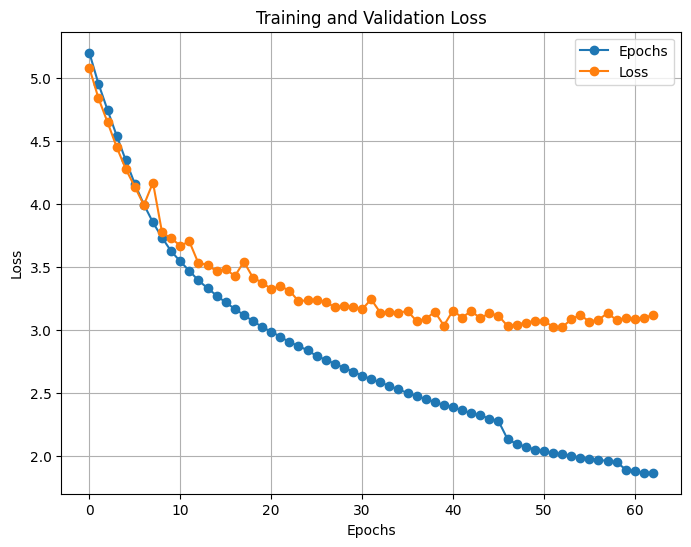

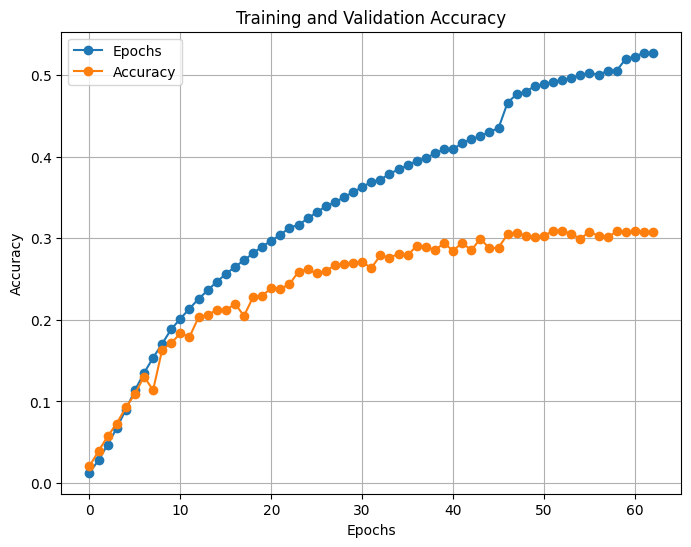

0.3092


MobileNetClassificationWrapper(
  (computations): MobileNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (layer1): DepthwiseSeparableConvolution(
      (conv_depth): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (relu): ReLU()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2): DepthwiseSeparableConvolution(
      (conv_depth): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (relu): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
 

In [7]:
parameters = {
    "batch_size" : 50,
    'epochs' : 25,
    'lr_optimizer': 1e-3,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4, # 1e-5
    'patience': 4,
    'early_stopper': 8,
    'momentum' : 0.9
}

train_transforms = Compose([
    ToTensor(),
    v2.RandomVerticalFlip(0.5),
    v2.RandomHorizontalFlip(0.5),
    # v2.RandomErasing(p=0.3, scale=(0.05, 0.1)),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = Compose([
    ToTensor(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

data = {
    "train": DataLoader(TinyImageNet(TINY_IMAGENET_TRAIN, transform=train_transforms, train=True), batch_size=parameters["batch_size"], shuffle=True, num_workers=3),
    "validation": DataLoader(TinyImageNet(TINY_IMAGENET_VAL, transform=test_transforms, train=False), batch_size=parameters["batch_size"], shuffle=True, num_workers=3),
}    

model = MobileNetClassificationWrapper()
execute_pipeline(model, data, parameters)
model.to("cpu")


In [8]:
import csv

TRAIN_DATA = "./nyu_data/data/nyu2_train.csv"
TEST_DATA = "./nyu_data/data/nyu2_test.csv"

class DepthImageDataset(Dataset):
    def __init__(self, csv_file_name, transform=None, label_transform=None):
        self.transform = transform
        self.label_transform = label_transform
        self.files_paths = []
        self.label_paths = []
        with open(csv_file_name, mode ='r') as file:
            csvFile = csv.reader(file)
            for lines in csvFile:
                self.files_paths.append("./nyu_data/" + lines[0])
                self.label_paths.append("./nyu_data/" + lines[1])
    
    def __len__(self):
        return len(self.files_paths)
    
    def get_my_item(self, idx):
        return self.__getitem__(idx)

    def __getitem__(self, idx):
        img = cv2.imread(self.files_paths[idx], flags=cv2.IMREAD_COLOR_RGB)
        depth_img = cv2.imread(self.label_paths[idx], flags=cv2.IMREAD_UNCHANGED)
        # img = img.astype(np.float32)
        depth_img = depth_img.astype(np.float32)
        depth_img = depth_img / 65535.0
        img = img if (self.transform == None) else self.transform(img)
        depth_img = depth_img if (self.label_transform == None) else self.label_transform(depth_img)
        return img, depth_img

In [9]:
def compute_depth_accuracy_batch_photos(found_depth: torch.Tensor, depth: torch.Tensor, epsilon=1e-6):
    relative_error = torch.abs(found_depth - depth) / (depth + epsilon) 
    right_examples = relative_error < 0.25
    total_elements = right_examples.numel()  
    return torch.sum(right_examples).float() / total_elements


def train_depth(model, dataloader, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    model.to(device)
    train_loss = 0
    train_accuracy = 0 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.sqrt(criterion(outputs, labels))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += compute_depth_accuracy_batch_photos(outputs, labels).item()
    return train_loss / len(dataloader), train_accuracy / len(dataloader) 

def test_depth(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        validation_loss = 0
        validation_accuracy = 0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            validation_loss += criterion(out, labels).item()
            validation_accuracy += compute_depth_accuracy_batch_photos(out, labels).item()
        return validation_loss / len(dataloader), validation_accuracy / len(dataloader)
    
def train_depth_model(model, data, criterion, optimizer, lr_scheduler, epochs, early_stopper : EarlyStopping):
    train_info = {
        "train_loss": [],
        "validation_loss" : [],
        "train_accuracy": [],
        "validation_accuracy" : []
    }
    max_acc = 0
    for i in range(epochs):
        train_loss, train_acc = train_depth(model, data["train"], optimizer, criterion)
        val_loss, val_acc = test_depth(model, data["validation"], criterion)
        if (val_acc > max_acc):
            max_acc = val_acc
            print("acuratete maxima la epoca", i)
        lr_scheduler.step(val_loss)
        print(val_loss, val_acc, "epoch: ", i)
        train_info["train_loss"].append(train_loss)
        train_info["validation_loss"].append(val_loss)
        train_info["train_accuracy"].append(train_acc)
        train_info["validation_accuracy"].append(val_acc)
        if not early_stopper.should_continue(val_loss): break
    return train_info


In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
SIZE = (224, 224)

parameters = {
    "batch_size" : 8,
    'epochs' : 30,
    'lr_optimizer': 1e-2,
    'gamma_lr': 0.3,
    'weight_decay_factor': 1e-4,
    'patience': 2,
    'early_stopper': 5,
    "momentum" : 0.9,
}

train_transforms = Compose([
    ToTensor(),
    Resize(size=SIZE),
])


test_transforms = Compose([
    ToTensor(),
    Resize(size=SIZE),
])

label_transforms = Compose([
    ToTensor(),
    Resize(size=SIZE),
])

data = {
    "train": DataLoader(DepthImageDataset(TRAIN_DATA, transform=train_transforms, label_transform=label_transforms), batch_size=parameters["batch_size"], shuffle=True, num_workers=4),
    "validation": DataLoader(DepthImageDataset(TEST_DATA, transform=test_transforms, label_transform=label_transforms), batch_size=1, shuffle=True, num_workers=4)
}

# model = FastDepth()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# early_stopper = EarlyStopping(model, parameters["early_stopper"],"./depth_model.pth")
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=parameters["lr_optimizer"], momentum=parameters["momentum"], weight_decay=parameters["weight_decay_factor"])
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=parameters['gamma_lr'], patience=parameters['patience'])  
# train_info = train_depth_model(model, data, criterion, optimizer,
#                          lr_scheduler, parameters['epochs'], early_stopper)

# plot_losses(train_info["train_loss"], train_info["validation_loss"], 
#             "Epochs", "Loss", "Training and Validation Loss")
# plot_losses(train_info["train_accuracy"], train_info["validation_accuracy"], 
#             "Epochs", "Accuracy", "Training and Validation Accuracy")

# new_model = FastDepth()
# new_model.load_state_dict(torch.load("./depth_model.pth", weights_only=True))
# new_model.to(device)
# _, accuracy  = test_depth(new_model, data["validation"], criterion)
# print(accuracy)
# model.to("cpu")

In [12]:
# model = FastDepth()
# model.load_state_dict(torch.load("./depth_model.pth", weights_only=True))
model.to("cpu")

def compute_depth_accuracy_batch_photos(found_depth : torch.tensor, depth : torch.tensor):
    right_examples = torch.div(torch.abs(found_depth - depth), depth) < 0.1
    size = right_examples.shape[0] * right_examples.shape[1] * right_examples.shape[2] * right_examples.shape[3]
    return torch.sum(right_examples) / size

for iddx, (images, labels) in enumerate(data["validation"]):
    out = model(images)
    print(torch.max(labels), torch.min(labels))
    print(torch.max(out), torch.min(out))
    print(compute_depth_accuracy_batch_photos(out, labels))
    initial_image = images[0].permute((1, 2, 0))
    labels_image = labels[0].permute((1, 2, 0))
    output_image = out[0].permute((1, 2, 0))
    # initial_image = (initial_image.detach().cpu().numpy().squeeze())
    labels_image = (labels_image.detach().cpu().numpy().squeeze())
    output_image = (output_image.detach().cpu().numpy().squeeze())
    plt.figure(figsize=(24, 24))
    plt.subplot(1, 3, 1) 
    plt.imshow(initial_image)
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output_image)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(labels_image)
    plt.axis('off')
    break

tensor(0.0292) tensor(0.0109)
tensor(8.9557, grad_fn=<MaxBackward1>) tensor(-9.8373, grad_fn=<MinBackward1>)


RuntimeError: The size of tensor a (200) must match the size of tensor b (224) at non-singleton dimension 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.46493173..253.57822].


tensor(167.7042, grad_fn=<MaxBackward1>) tensor(11.7782, grad_fn=<MinBackward1>)
[[80.08285  80.08285  79.42819  ... 65.468094 69.969086 69.969086]
 [80.08285  80.08285  79.42819  ... 65.468094 69.969086 69.969086]
 [79.7741   79.7741   78.09377  ... 60.745625 65.57826  65.57826 ]
 ...
 [34.467754 34.467754 25.525318 ... 29.273735 36.046455 36.046455]
 [44.33982  44.33982  34.384895 ... 35.023396 42.877453 42.877453]
 [44.33982  44.33982  34.384895 ... 35.023396 42.877453 42.877453]]


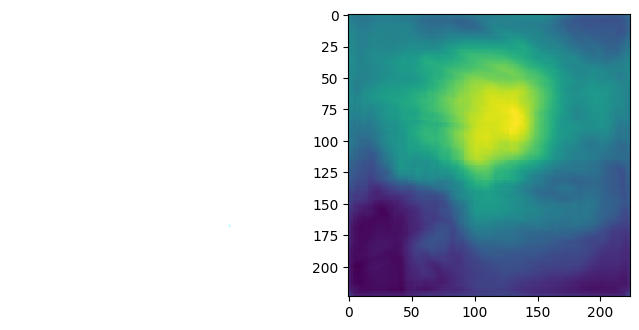

In [ ]:
img = cv2.imread("./inside_home.jpg")
img = img.astype(np.float32)
img = test_transforms(img)
for_plt = img.permute((1, 2, 0))
for_plt = for_plt.detach().cpu().numpy().squeeze()
for_model = img.unsqueeze(dim=0)
depth_this_image = model(for_model)
print(torch.max(depth_this_image), torch.min(depth_this_image))
depth_this_image = depth_this_image.detach().cpu().numpy().squeeze()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) 
plt.imshow(for_plt)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(depth_this_image)
print(depth_this_image)

In [1]:
torch_input = torch.rand(size=(1, 3, 224, 224))
torch.onnx.export(model, torch_input, "fast_depth.onnx", opset_version=11)

NameError: name 'torch' is not defined

In [23]:
import onnxruntime
session = onnxruntime.InferenceSession("./fast_depth.onnx")
print("ONNX model loaded successfully in ONNX Runtime")

ONNX model loaded successfully in ONNX Runtime
